# Imports and libraries

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from colorama import Fore, Style
from datetime import timedelta
from feature_engine.encoding import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from time import time
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
hide_toggle()

# Data preparation

In [3]:
train_p1 = pd.read_csv("train.csv",index_col="id")
display(train_p1.head())
print("Synthetic",train_p1.shape)
hide_toggle()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


Synthetic (15304, 11)


In [4]:
train_p2 = pd.read_csv("healthcare-dataset-stroke-data.csv",index_col="id")
display(train_p2.head())
print('Real',train_p2.shape)
hide_toggle()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Real (5110, 11)


In [5]:
train = pd.concat([train_p1, train_p2], ignore_index=True)
display(train.head())
print("Merged",train.shape)
hide_toggle()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


Merged (20414, 11)


In [6]:
train.info()
hide_toggle()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             20414 non-null  object 
 1   age                20414 non-null  float64
 2   hypertension       20414 non-null  int64  
 3   heart_disease      20414 non-null  int64  
 4   ever_married       20414 non-null  object 
 5   work_type          20414 non-null  object 
 6   Residence_type     20414 non-null  object 
 7   avg_glucose_level  20414 non-null  float64
 8   bmi                20213 non-null  float64
 9   smoking_status     20414 non-null  object 
 10  stroke             20414 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.7+ MB


# Missing values handling

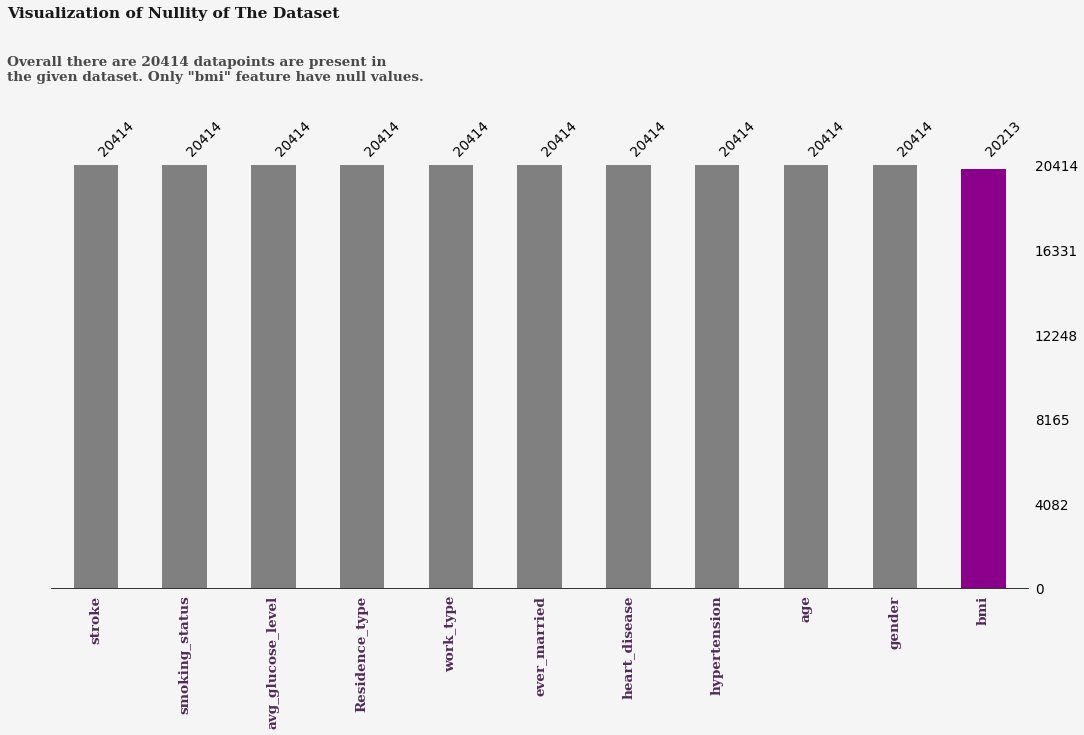

In [7]:
color = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','#8B008B','#fe346e']
fig, ax = plt.subplots(figsize = (18,8), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')


msno.bar(train, sort = 'descending', 
         color = color, 
         ax = ax, fontsize =14,
         labels = 'off',filter = 'top')

ax.text(-1,1.35,'Visualization of Nullity of The Dataset',{'font': 'Serif', 'size': 16,'weight':'bold', 'color':'black'},alpha = 0.9)
ax.text(-1,1.2,'Overall there are 20414 datapoints are present in \nthe given dataset. Only "bmi" feature have null values.',{'font': 'Serif', 'size': 14, 'weight':'bold', 'color':'black'}, alpha = 0.7)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, 
                   ha = 'center', **{'font': 'Serif', 'size': 14,'weight':'bold','color':'#512b58'}, alpha = 1)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)

fig.show()
hide_toggle()

In [8]:
train['bmi'].fillna(train['bmi'].mean(),inplace = True)

# Distribution of the data

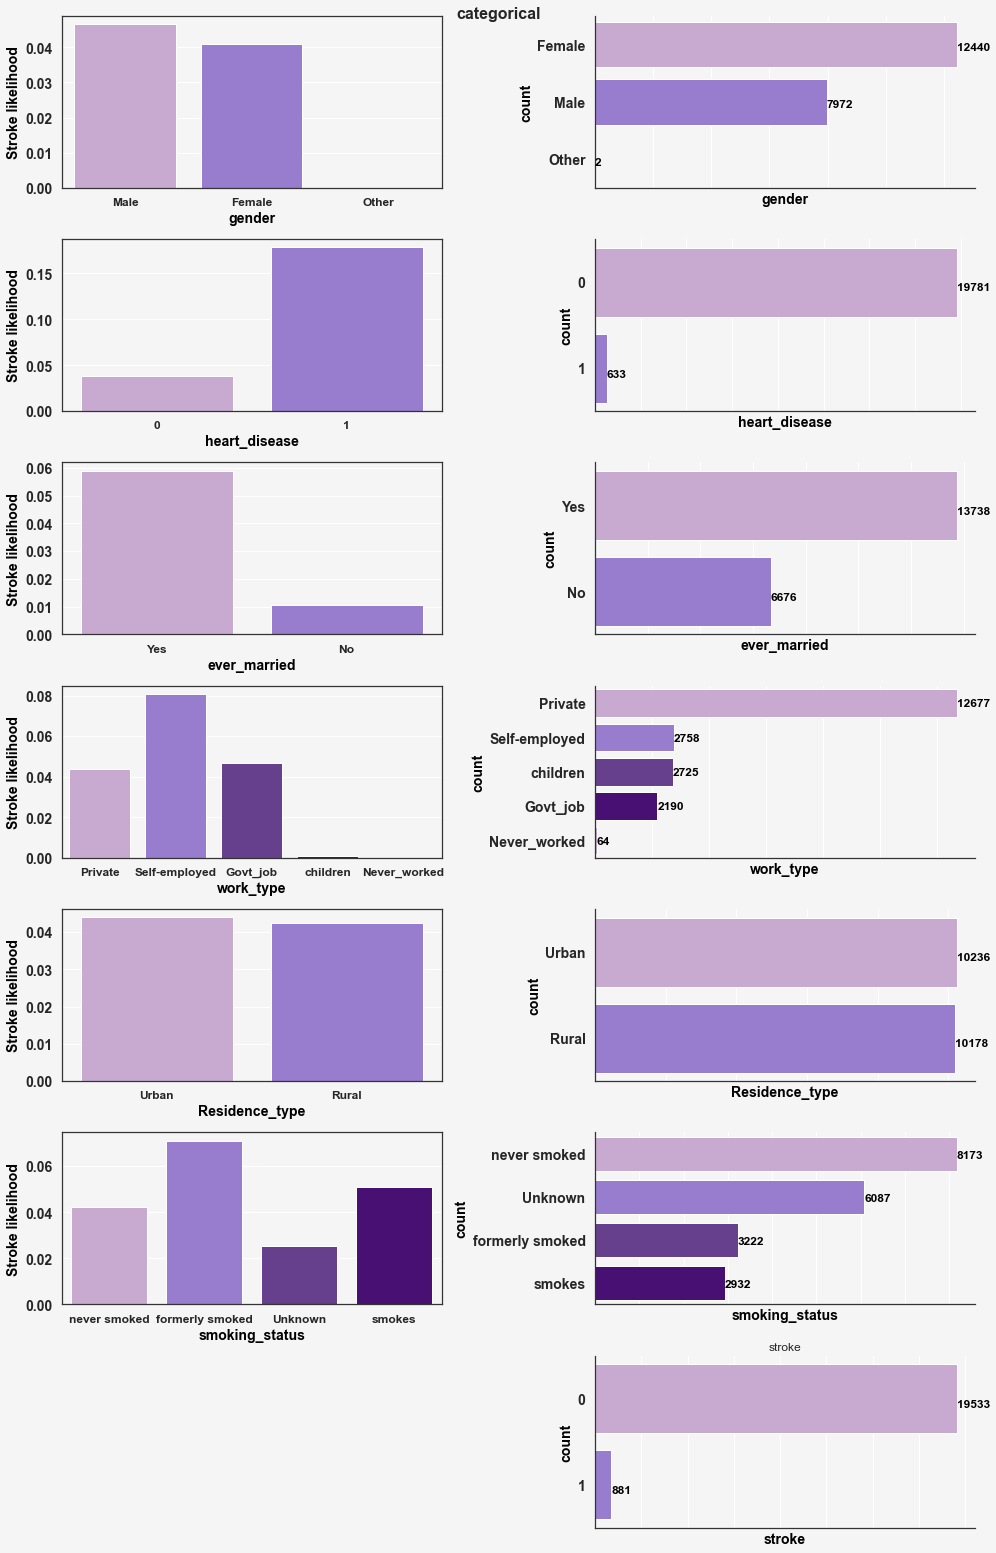

In [9]:
plt.style.use('ggplot')

rc = {
    "axes.facecolor":"#F5F5F5",                      #"#FFF9ED",
    "figure.facecolor":"#F5F5F5",                             #"#FFF9ED",
    "axes.edgecolor":"#333333"                             #"#383838"
}

sns.set(rc=rc)
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    """Draws the pie and count plots for categorical variables.
    
    Args:
        df: train or test dataframes
        col_list: a list of the selected categorical variables.
        title_name: 'Train' or 'Test' (default 'Train')
        
    Returns:
        subplots of size (len(col_list), 2)
    """
    f, axes = plt.subplots(len(col_list), 2, figsize=(14, 22))
    plt.subplots_adjust(wspace=0)
    
    for col_name, ax in zip(col_list, axes):
        s1 = df[col_name].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        #outer_colors = ['00000', '#eb5e00', '#ff781f', '#ff9752', '#ff9752']
        #inner_colors = ['#ff6905', '#ff8838', '#ffa66b']
        outer_colors = ['00000', '#663399','#8A2BE2','#9370DB','8B008B']
        inner_colors = ['#AB83A1','#800080','#4B0082']

        

        textprops = {
            'size':18, 
            'weight': 'bold',
            'color':'white'
        }

      

        x = s1
        y = s1.index.astype(str)
        palette = ['#663399','#8A2BE2','#9370DB','#8B008B','#800080','#4B0082','#AB83A1']
        cp = ['#CBA3D8', '#9370DB', '#663399', '#4B0082']
        sns.barplot(
            x=x, y=y, ax=ax[1],                                           #'YlOrBr_r'
            palette=cp, orient='horizontal'
        )
        if col_name != 'stroke':
            sns.barplot(data = df, x = col_name, y = 'stroke', palette=cp,ax=ax[0],ci =None)
            plt.setp(ax[0].get_yticklabels(), fontweight="bold",fontsize="14")
            plt.setp(ax[0].get_xticklabels(), fontweight="bold",fontsize="12")
            ax[0].set_xlabel(col_name, fontweight="bold", color='black',fontsize="14")
            ax[0].set_ylabel('Stroke likelihood', fontweight="bold", color='black',fontsize="14")
        else:
            ax[0].axis('off')

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,      
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='black', 
                         fontweight='bold', fontsize=12)

        plt.title(col_name)
        plt.setp(ax[1].get_yticklabels(), fontweight="bold",fontsize="14")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold",fontsize="14")
        ax[1].set_xlabel(col_name, fontweight="bold", color='black',fontsize="14")
        ax[1].set_ylabel('count', fontweight="bold", color='black',fontsize="14")

    f.suptitle("categorical", fontsize=16, fontweight='bold')
    plt.tight_layout()    
    plt.show()
    
def pair_plot(df: pd.core.frame.DataFrame, title_name: str, hue: str) -> None:
    """Draws the pairplot for the selected dataframe.
    
    Args:
        df: train, test or combined dataframes
        title_name: any string title
        hue: a specified categorical column name
        
    Returns:
        pairplots
    """
    s = sns.pairplot(df, hue=hue, palette=['#9E3F00', '#eb5e00'])
    s.fig.set_size_inches(16, 12)
    s.fig.suptitle(title_name, y=1.08)
    plt.show()
    
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    """Draws the correlation heatmap plot.
    
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True)
    plt.title(title_name)
    plt.show()
    
selected_columns = ['gender', 'heart_disease', 'ever_married', 'work_type',
                    'Residence_type', 'smoking_status', 'stroke']
plot_count(train, selected_columns)
hide_toggle()

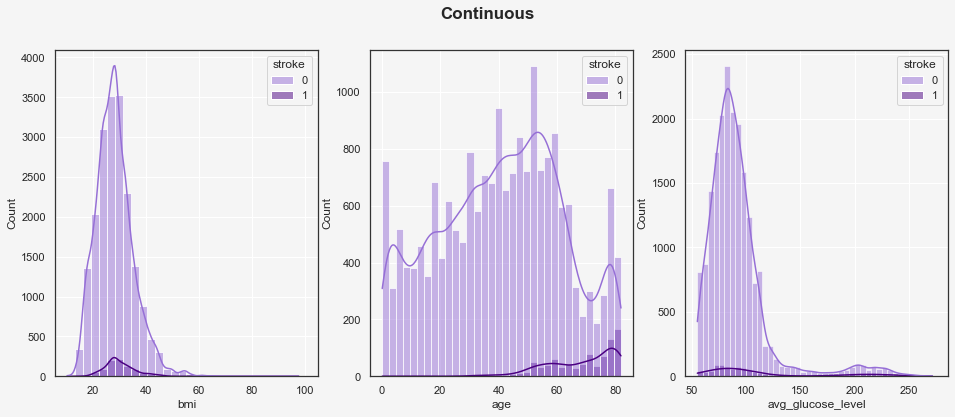

In [10]:
fig, axs = plt.subplots(1,3, figsize=(16,6))
#palette = ['#663399','#8A2BE2','#9370DB','#8B008B','#800080','#4B0082','#AB83A1']
#palette = ['#008080','#800080']
palette = ['#966FD6', '#4B0082']
#sns.set_theme()
sns.histplot(train,x=train.bmi,hue='stroke',kde=True,palette=palette,ax=axs[0],binwidth=3)
sns.histplot(train,x=train.age,hue='stroke',kde=True,palette=palette,ax=axs[1])
sns.histplot(train,x=train.avg_glucose_level,hue='stroke',kde=True,palette=palette,ax=axs[2],binwidth=5)
title_font = {'fontweight': 'bold', 'fontsize': 17}
fig.suptitle('Continuous', **title_font)
fig.show()
hide_toggle()

# Outliers

In [11]:
def find_outliers(df, col):
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    IQR=q3-q1
    upper = q3 + IQR*1.5
    lower = q1 - IQR*1.5
    return df[(df[col] >= lower) & (df[col] <= upper)]
hide_toggle()

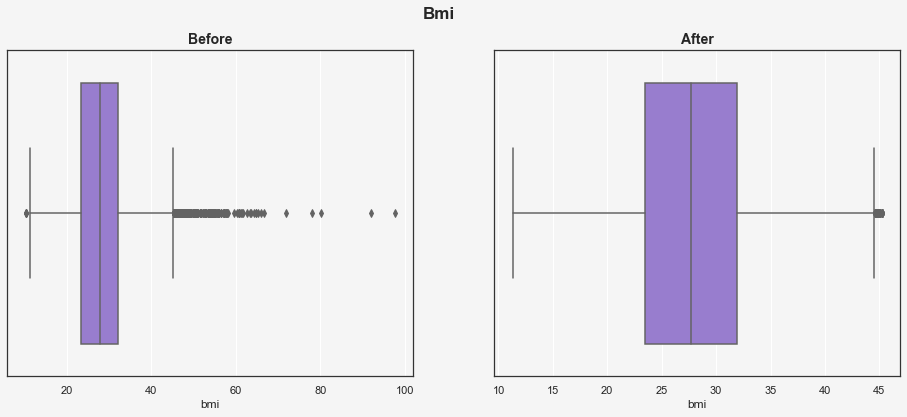

In [12]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
palette = ['#9370DB']
title_font = {'fontweight': 'bold', 'fontsize': 17}
Sub_title_font = {'fontweight': 'bold', 'fontsize': 14}
sns.boxplot(train.bmi,palette=palette,ax=axs[0]).set_title("Before", **Sub_title_font)
train = find_outliers(train,"bmi")
sns.boxplot(train.bmi,palette=palette,ax=axs[1]).set_title("After", **Sub_title_font)
fig.suptitle('Bmi', **title_font)
fig.show()
hide_toggle()

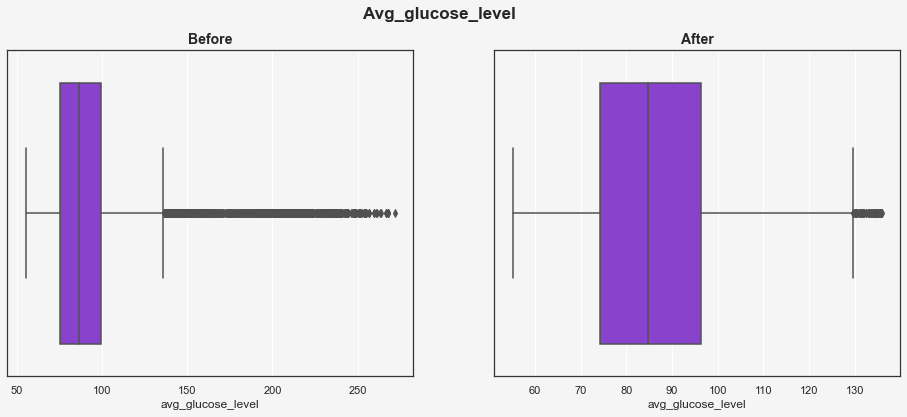

In [13]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
palette=['#8A2BE2']
sns.boxplot(train.avg_glucose_level,palette=palette,ax=axs[0]).set_title("Before", **Sub_title_font)
train = find_outliers(train,"avg_glucose_level")
sns.boxplot(train.avg_glucose_level,palette=palette,ax=axs[1]).set_title("After", **Sub_title_font)
fig.suptitle('Avg_glucose_level', **title_font)
fig.show()
hide_toggle()

# Invalid entries

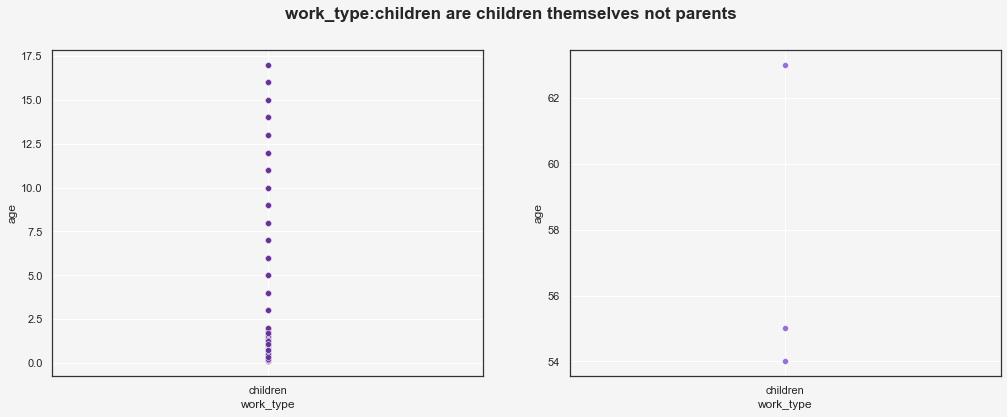

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(17, 6))
sns.scatterplot(data=train[(train.work_type=='children')&(train.age<18)], x='work_type', y='age',ax=axes[0],color='#663399')
sns.scatterplot(data=train[(train.work_type=='children')&(train.age>18)], x='work_type', y='age',ax=axes[1],color='#9370DB')
fig.suptitle('work_type:children are children themselves not parents', **title_font)
fig.show()

In [15]:
invalid = train[(train.age<18) & (train['work_type'] != 'children') & (train['work_type']!='Never_worked')]

In [16]:
invalid=invalid.append(train[(train.work_type=='children') & (train.age>18)])
invalid=invalid.append(train[(train.age<12) & ((train.smoking_status=='smokes')|(train.smoking_status=='formerly smoked'))])
invalid=invalid.append(train[(train.age<18) & (train.ever_married=='Yes')])
invalid =invalid[~invalid.index.duplicated()]

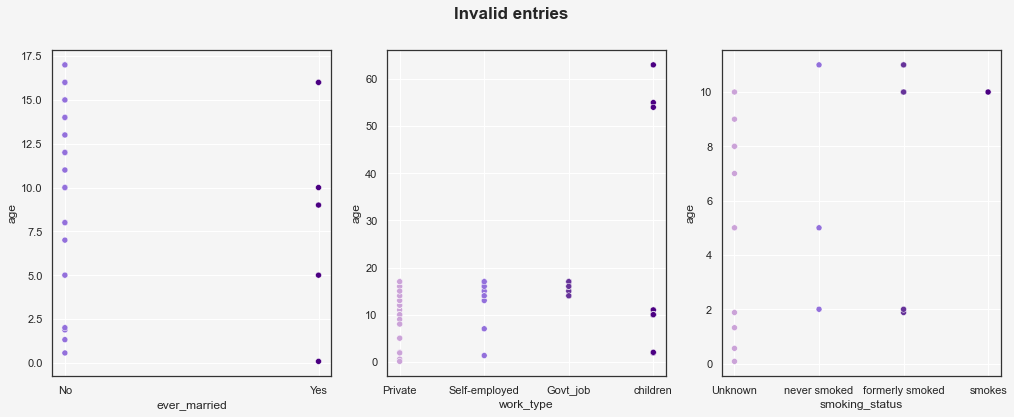

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(17, 6))
cp = ['#CBA3D8', '#9370DB', '#663399', '#4B0082']
c= invalid[invalid.age<18]
sns.scatterplot(data=c,x=c.ever_married,y=c.age,hue='ever_married',palette=[cp[1],cp[-1]],legend = False,ax=axes[0])
sns.scatterplot(data=invalid,x=invalid.work_type,y=invalid.age,hue='work_type',palette=cp,legend = False,ax=axes[1])
d=invalid[invalid.age<12]
sns.scatterplot(data=d,x=d.smoking_status,y=d.age,hue='smoking_status',palette=cp,legend = False,ax=axes[2])
fig.suptitle('Invalid entries', **title_font)
fig.show()

In [18]:
train.drop(invalid.index,inplace=True)

# Adjustments

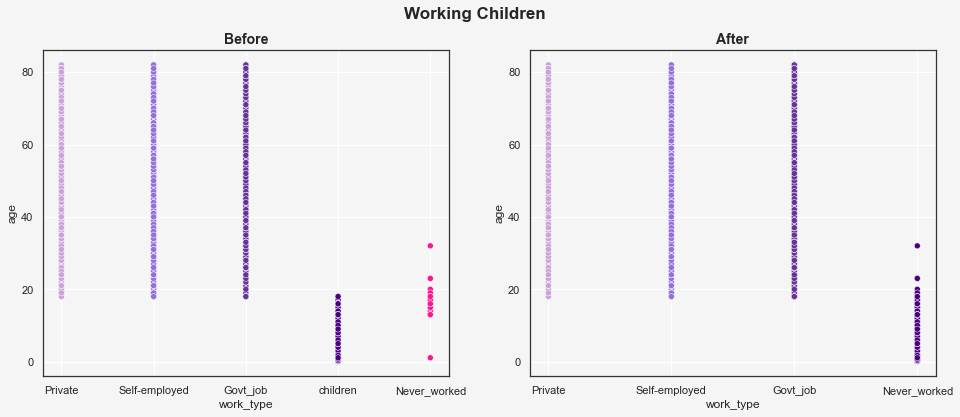

In [19]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
cp2 = ['#CBA3D8', '#9370DB', '#663399', '#4B0082', '#FF1493']
sns.scatterplot(data=train,x=train.work_type,y=train.age,hue='work_type',palette=cp2,legend = False,ax=axs[0]).set_title("Before", **Sub_title_font)
train['work_type'] = train['work_type'].replace('children','Never_worked')
sns.scatterplot(data =train,x=train.work_type,y=train.age,hue='work_type',palette=cp,legend = False,ax=axs[1]).set_title("After", **Sub_title_font)
fig.suptitle('Working Children', **title_font)
fig.show()

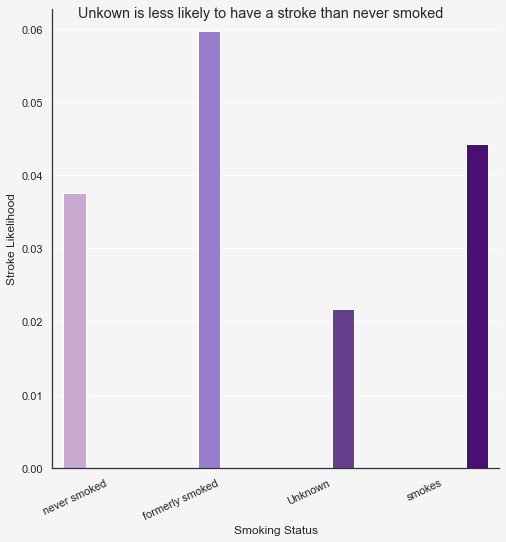

In [20]:
hue=['#CBA3D8', '#9370DB', '#663399', '#4B0082']
plot1 = sns.catplot(data = train, x = 'smoking_status', y = 'stroke', kind = 'bar', hue='smoking_status', ci=None,size= 7,palette=hue)
plot1.set_xticklabels(rotation=25, horizontalalignment='right')
plot1.set_xlabels('Smoking Status', fontsize = 12) 
plot1.set_ylabels('Stroke Likelihood', fontsize = 12);
plot1.fig.suptitle('Unkown is less likely to have a stroke than never smoked')
plot1.fig.show()

In [21]:
train['smoking_status'] = train['smoking_status'].replace('Unknown','never smoked')

In [22]:
train['gender'] = train['gender'].replace('Other','Male')

# EDA

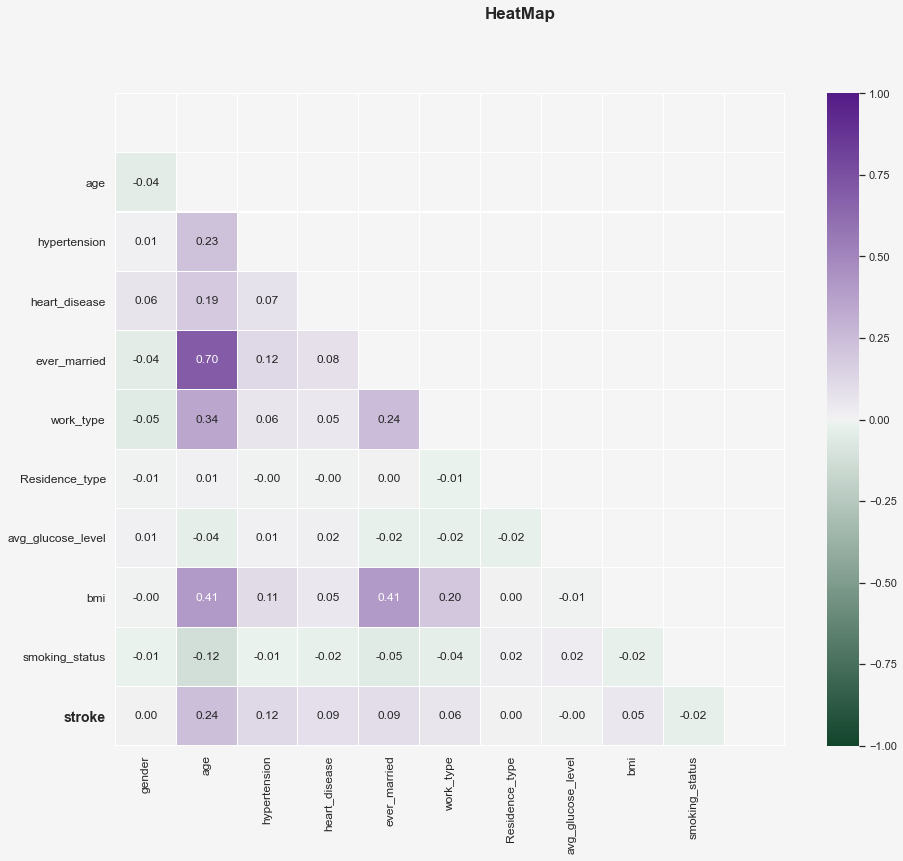

In [23]:
train1=train.copy()
num_cols = train1.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('hypertension') # in fact, this is a categorical feature
num_cols.remove('heart_disease') # and this is too
cat_cols = list(set(train1.columns) - set(num_cols))
for col in cat_cols:
    le = LabelEncoder()
    train1[col] = le.fit_transform(train1[col])
matrix = np.triu(train1.corr())
plt.figure(figsize = (15, 12))
a = sns.heatmap(train1.corr(), mask=matrix, annot=True, annot_kws={'fontsize': 12}, 
            #cmap=sns.diverging_palette(230, 10, as_cmap=True), cbar=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7,as_cmap=True),cbar=True,
            vmin=-1, vmax=1, fmt='.2f', linewidths=0.1, linecolor='white')
plt.xticks(size=12)
plt.yticks(size=12)
a.set_xticks(a.get_xticks()[:-1])
a.set_yticks(a.get_yticks()[1:])
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.suptitle('HeatMap',**title_font)
plt.show()

Feature ranking:
1. feature 1 (0.750665)
2. feature 5 (0.057903)
3. feature 7 (0.055881)
4. feature 2 (0.033314)
5. feature 6 (0.028806)
6. feature 0 (0.025676)
7. feature 3 (0.024640)
8. feature 4 (0.023114)


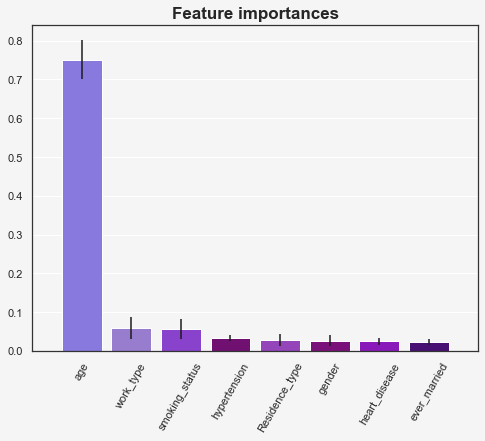

In [24]:
features=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status']
sp = ['#7B68EE', '#9370DB', '#8A2BE2', '#800080', '#9932CC', '#8B008B', '#9400D3', '#4B0082']
X = train1[features]
y = train1['stroke']
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
    
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(8,6))

plt.title("Feature importances",**title_font)
sns.barplot(x=np.array(features)[indices], y=importances[indices], palette=sp,yerr=std[indices],ci=None)
plt.xticks(range(X.shape[1]), np.array(features)[indices],rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# Modeling

In [25]:
test= pd.read_csv('test.csv', index_col='id')

test['smoking_status'] = test['smoking_status'].replace('Unknown','never smoked')
test['gender'] = test['gender'].replace('Other','Male')
test['work_type'] = test['work_type'].replace('children','Never_worked')


numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['hypertension', 'heart_disease',
    'ever_married','gender','Residence_type', 'work_type',  'smoking_status']
target = 'stroke'

train_us = pd.concat([train[train['stroke'] == 0].sample(673,random_state=2004),train[train['stroke'] == 1]])

cv = StratifiedKFold(shuffle=True, random_state=2023)
all_features = numerical_features + categorical_features

# Create a copy of train df to modify inplace
train_df_ = train_us[all_features].copy()

# cast categorical features as categorical type
train_df_[categorical_features] = (
    train_df_[categorical_features].astype('category')
)

target = train_us['stroke']

oof_preds = pd.Series(0, index=train_us.index)
oof_predssss = pd.Series(0, index=train_us.index)
start = time()
tr_auc = []
vl_auc = []
pipelines = []

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_us, target)):
    X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]
    
    X_tr = X_tr.copy()
    X_vl = X_vl.copy()
    
    model = LogisticRegression(random_state=10)
    encoder = OneHotEncoder(drop_last=True, variables=categorical_features)
    scaler = SklearnTransformerWrapper(StandardScaler(), variables=numerical_features)
    
    X_tr = encoder.fit_transform(X_tr)
    X_tr = scaler.fit_transform(X_tr)
    
    X_vl = encoder.transform(X_vl)
    X_vl = scaler.transform(X_vl)

    start_fold = time()
    print('_'*50)
    print(f'Fold {fold} | {timedelta(seconds=int(time()-start))}')
    
    model.fit(X_tr, y_tr)
    
    oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]
    oof_predssss.iloc[vl_ix] = model.predict(X_vl)
    tr_auc.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
    vl_auc.append(roc_auc_score(y_vl, model.predict_proba(X_vl)[:, 1]))
    pipelines.append([encoder, scaler, model])

    print(f'Val AUC: {Fore.BLUE}{vl_auc[-1]}{Style.RESET_ALL}')

print()
print(f'Mean Val AUC: {Fore.GREEN}{np.mean(vl_auc)}{Style.RESET_ALL}')
print(f'OOF AUC:      {Fore.GREEN}{roc_auc_score(target, oof_preds)}{Style.RESET_ALL}')

preds = pd.Series(0, index=test.index)
X_test = test[all_features].copy()

for pipeline in pipelines:
    X_test = test[all_features].copy()
    encoder, scaler, model = pipeline
    X_test = encoder.transform(X_test)
    X_test = scaler.transform(X_test)
    preds += model.predict_proba(X_test)[:, 1]

preds /= len(pipelines)
preds.rename('stroke', inplace=True)
preds.to_csv('submission_under_sampling.csv')

__________________________________________________
Fold 0 | 0:00:00
Val AUC: 0.8649108367626885
__________________________________________________
Fold 1 | 0:00:00
Val AUC: 0.9064123825317856
__________________________________________________
Fold 2 | 0:00:00
Val AUC: 0.8196793808734106
__________________________________________________
Fold 3 | 0:00:00
Val AUC: 0.8577114427860696
__________________________________________________
Fold 4 | 0:00:00
Val AUC: 0.8589275843007186

Mean Val AUC: 0.8615283254509347
OOF AUC:      0.8609318458301412


In [26]:
train_us.stroke.value_counts()

0    673
1    673
Name: stroke, dtype: int64

In [27]:
from sklearn.metrics import classification_report
print(classification_report(target, oof_predssss))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       673
           1       0.77      0.81      0.79       673

    accuracy                           0.79      1346
   macro avg       0.79      0.79      0.79      1346
weighted avg       0.79      0.79      0.79      1346



In [28]:
oof_preds.describe()

count    1346.000000
mean        0.498673
std         0.319808
min         0.004514
25%         0.179483
50%         0.528711
75%         0.822202
max         0.968484
dtype: float64

In [29]:
def score_fnc(data_arr1, data_arr2):
    auc = roc_auc_score(data_arr1, data_arr2)
    return auc

def BootStrap(data_arr1, data_arr2, n_bootstraps):

    # initialization by bootstraping
    n_bootstraps = n_bootstraps
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(data_arr2), len(data_arr2))

        if len(np.unique(data_arr1[indices])) < 2:
            # We need at least one sample from each class
            # otherwise reject the sample
            continue
        else:
            score = score_fnc(data_arr1[indices], data_arr2[indices])
            bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    if len(sorted_scores)==0:
        return 0., 0.
    # Computing the lower and upper bound of the 95% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

    return sorted_scores, confidence_lower, confidence_upper

In [30]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, th = roc_curve(target, oof_preds, pos_label=1)
auroc = auc(fpr, tpr)
print('auroc={:.4f}'.format(auroc))

auroc=0.8609


In [31]:
sorted_scores, auroc_lower, auroc_upper = BootStrap(target.reset_index(drop=True), oof_preds.reset_index(drop=True),n_bootstraps=1000)
auroc_text = 'AUROC = {:.4f} ({:.4f} - {:.4f})'.format(auroc, auroc_lower, auroc_upper)
print(auroc_text)

AUROC = 0.8609 (0.8409 - 0.8813)


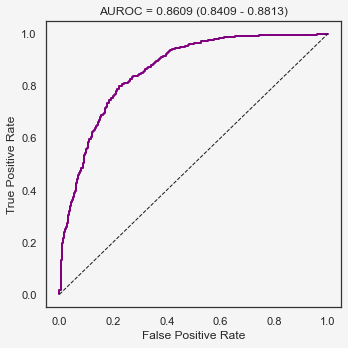

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, lw=2, alpha=1., color='purple')
ax.plot([0, 1], [0, 1], 'k--', lw=1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim((-0.05,1.05))
ax.set_xticks(np.arange(0,1.05,0.2))
# ax.set_xticklabels('')
ax.set_ylim((-0.05,1.05))
ax.set_yticks(np.arange(0,1.05,0.2))
# ax.set_yticklabels('')
ax.set_axisbelow(True)
ax.grid(color='gray') #, linestyle='dashed')
ax.set_title(auroc_text)
# ax.legend(framealpha=1.)

fig.tight_layout()
plt.show()

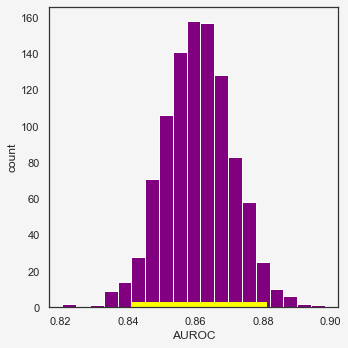

In [33]:
fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.hist(sorted_scores, bins=19, color='purple')
ax2.hlines(0,auroc_lower, auroc_upper, 'yellow', lw=10)

ax2.set_xlabel('AUROC')
ax2.set_ylabel('count')
# ax.set_xlim((-0.05,1.05))
# ax.set_xticks(np.arange(0,1.05,0.2))
# # ax.set_xticklabels('')
# ax.set_ylim((-0.05,1.05))
# ax.set_yticks(np.arange(0,1.05,0.2))
# # ax.set_yticklabels('')
ax2.set_axisbelow(True)
ax2.grid(color='gray') #, linestyle='dashed')
# ax.set_title(auroc_text)
# # ax.legend(framealpha=1.)

fig2.tight_layout()

plt.show()

In [34]:
test= pd.read_csv('test.csv', index_col='id')

test['smoking_status'] = test['smoking_status'].replace('Unknown','never smoked')
test['gender'] = test['gender'].replace('Other','Male')
test['work_type'] = test['work_type'].replace('children','Never_worked')


numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status']
target = 'stroke'
from sklearn.ensemble import RandomForestClassifier
from colorama import Fore, Style
from datetime import timedelta
from feature_engine.encoding import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from time import time
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

#from xgboost.callback import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


cv = StratifiedKFold(shuffle=True, random_state=2023,n_splits=5)
all_features = numerical_features + categorical_features

# Create a copy of train df to modify inplace
train_df_ = train[all_features].copy()

# cast categorical features as categorical type
train_df_[categorical_features] = (
    train_df_[categorical_features].astype('category')
)

target = train['stroke']

oof_preds = pd.Series(0, index=train.index)
final_tr_auc = []
final_vl_auc = []
final_tr_mse = []
final_vl_mse = []
for k in range(1,5):
    tr_auc = []
    vl_auc = []
    tr_mse = []
    vl_mse = []
    for fold, (tr_ix, vl_ix) in enumerate(cv.split(train, target)):
        X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
        X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]

        X_tr = X_tr.copy()
        X_vl = X_vl.copy()

        # model = LogisticRegression()
        model = Pipeline([
            ('poly_transform', PolynomialFeatures(degree = k)),
            ('regression', LogisticRegression())    
        ])
        encoder = OneHotEncoder(drop_last=True, variables=categorical_features)
        scaler = SklearnTransformerWrapper(StandardScaler(), variables=numerical_features)

        X_tr = encoder.fit_transform(X_tr)
        X_tr = scaler.fit_transform(X_tr)

        X_vl = encoder.transform(X_vl)
        X_vl = scaler.transform(X_vl)


        model.fit(X_tr, y_tr)

        #oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]
        tr_auc.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
        vl_auc.append(roc_auc_score(y_vl, model.predict_proba(X_vl)[:, 1]))
        tr_mse.append(mse(y_tr, model.predict_proba(X_tr)[:, 1]))
        vl_mse.append(mse(y_vl, model.predict_proba(X_vl)[:, 1]))

    final_tr_auc.append(np.mean(tr_auc))
    final_vl_auc.append(np.mean(vl_auc))
    final_tr_mse.append(np.mean(tr_mse))
    final_vl_mse.append(np.mean(vl_mse))

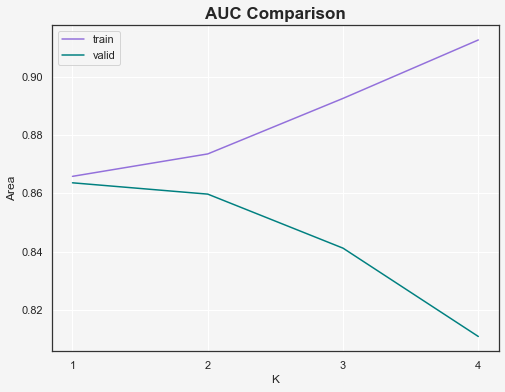

In [35]:
plt.figure(figsize=(8,6))
sns.lineplot(data=final_tr_auc,color='#9370DB',label="train")
sns.lineplot(data=final_vl_auc,color='#008080',label="valid")
x = [1,2,3,4]
xi = list(range(len(x)))
plt.xticks(xi, x)
plt.ylabel("Area")
plt.xlabel('K')
plt.legend()
plt.title('AUC Comparison',**title_font)
plt.show()

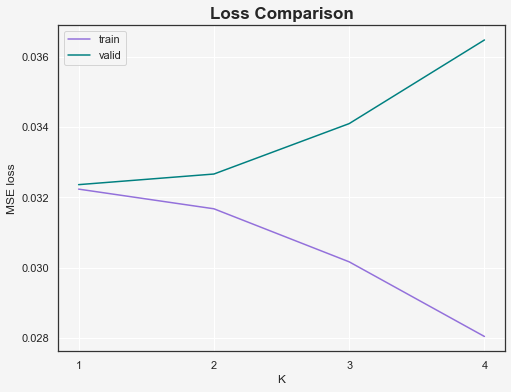

In [36]:
plt.figure(figsize=(8,6))
sns.lineplot(data= final_tr_mse,color='#9370DB',label="train")
sns.lineplot(data=final_vl_mse,color='#008080',label="valid")
x = [1,2,3,4]
xi = list(range(len(x)))
plt.xticks(xi, x)
plt.xlabel('K')
plt.ylabel("MSE loss")
plt.legend()
plt.legend()
plt.title('Loss Comparison',**title_font)
plt.show()

In [37]:
def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    df['blood_heart']= df.hypertension*df.heart_disease
    return df

In [38]:
test= pd.read_csv('test.csv', index_col='id')
t1=train.copy()
FE_df = generate_features(t1)
FE_test = generate_features(test)

FE_test['smoking_status'] = FE_test['smoking_status'].replace('Unknown','never smoked')
FE_test['gender'] = FE_test['gender'].replace('Other','Male')
FE_test['work_type'] = FE_test['work_type'].replace('children','Never_worked')


numerical_features = ['age', 'avg_glucose_level', 'bmi',"obesity",'age/bmi','age*bmi','bmi/prime']
categorical_features = ['hypertension', 'work_type', 'smoking_status','blood_heart']
target = 'stroke'



cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=2023)
all_features = numerical_features + categorical_features

# Create a copy of train df to modify inplace
train_df_ = FE_df[all_features].copy()

# cast categorical features as categorical type
train_df_[categorical_features] = (
    train_df_[categorical_features].astype('category')
)

target = train['stroke']

oof_preds = pd.Series(0, index=train_df_.index)
start = time()
tr_auc = []
vl_auc = []
pipelines = []

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df_, target)):
    X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]
    
    X_tr = X_tr.copy()
    X_vl = X_vl.copy()
    
    model = LogisticRegression(random_state=10)
    encoder = OneHotEncoder(drop_last=True, variables=categorical_features)
    scaler = SklearnTransformerWrapper(StandardScaler(), variables=numerical_features)
    
    X_tr = encoder.fit_transform(X_tr)
    X_tr = scaler.fit_transform(X_tr)
    
    X_vl = encoder.transform(X_vl)
    X_vl = scaler.transform(X_vl)

    start_fold = time()
    print('_'*50)
    print(f'Fold {fold} | {timedelta(seconds=int(time()-start))}')
    
    model.fit(X_tr, y_tr)
    
    oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]
    tr_auc.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
    vl_auc.append(roc_auc_score(y_vl, model.predict_proba(X_vl)[:, 1]))
    pipelines.append([encoder, scaler, model])

    print(f'Val AUC: {Fore.BLUE}{vl_auc[-1]}{Style.RESET_ALL}')

print()
print(f'Mean Val AUC: {Fore.GREEN}{np.mean(vl_auc)}{Style.RESET_ALL}')
print(f'OOF AUC:      {Fore.GREEN}{roc_auc_score(target, oof_preds)}{Style.RESET_ALL}')

preds = pd.Series(0, index=test.index)
X_test = test[all_features].copy()

for pipeline in pipelines:
    X_test = test[all_features].copy()
    encoder, scaler, model = pipeline
    X_test = encoder.transform(X_test)
    X_test = scaler.transform(X_test)
    preds += model.predict_proba(X_test)[:, 1]

preds /= len(pipelines)
preds.rename('stroke', inplace=True)
preds.to_csv('submission_FE.csv')

__________________________________________________
Fold 0 | 0:00:00
Val AUC: 0.8604065037174481
__________________________________________________
Fold 1 | 0:00:00
Val AUC: 0.8747653881836878
__________________________________________________
Fold 2 | 0:00:00
Val AUC: 0.8805168205454739
__________________________________________________
Fold 3 | 0:00:00
Val AUC: 0.8395818741377481
__________________________________________________
Fold 4 | 0:00:00
Val AUC: 0.8597431815769926

Mean Val AUC: 0.86300275363227
OOF AUC:      0.862540182386058


In [39]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [40]:
train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.10000,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.90000,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.30000,never smoked,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.80000,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.80000,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
20408,Female,13.0,0,0,No,Never_worked,Rural,103.08,18.60000,never smoked,0
20409,Female,80.0,1,0,Yes,Private,Urban,83.75,28.30228,never smoked,0
20410,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00000,never smoked,0
20411,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60000,never smoked,0


In [41]:
train_df=train.copy()
train_df = pd.get_dummies(train_df, columns=['gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
train_df

,age,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,...,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,28.0,79.53,31.10000,0,0,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
1,33.0,78.44,23.90000,0,0,1,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
2,42.0,103.00,40.30000,0,1,0,1,0,1,0,...,1,0,0,1,0,1,0,0,1,0
3,56.0,64.87,28.80000,0,0,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
4,24.0,73.36,28.80000,0,1,0,1,0,1,0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20408,13.0,103.08,18.60000,0,1,0,1,0,1,0,...,0,0,1,0,0,1,0,0,1,0
20409,80.0,83.75,28.30228,0,1,0,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0
20410,81.0,125.20,40.00000,0,1,0,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
20411,35.0,82.99,30.60000,0,1,0,1,0,1,0,...,1,0,0,0,1,1,0,0,1,0


In [42]:
train_df.stroke.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
test_df =pd.read_csv('test.csv',index_col='id')
test_df['smoking_status'] = test_df['smoking_status'].replace('Unknown','never smoked')
test_df['gender'] = test_df['gender'].replace('Other','Male')
test_df['work_type'] = test_df['work_type'].replace('children','Never_worked')
test_df= pd.get_dummies(test_df, columns=['gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
test_df

,age,avg_glucose_level,bmi,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,,,,
15304,57.0,82.54,33.4,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0
15305,70.0,72.06,28.5,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0
15306,5.0,103.72,19.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0
15307,56.0,69.24,41.4,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1
15308,32.0,111.15,30.1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25503,27.0,75.77,17.6,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0
25504,49.0,102.91,26.7,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0
25505,3.0,104.04,18.3,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0


In [44]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))



Y = train_df['stroke'].values
X = train_df.drop(['stroke'], axis=1)

In [45]:
params = {
        'min_child_weight': [10],
        'gamma': [1],
        'subsample': [0.6],
        'colsample_bytree': [0.8],
        'max_depth': [3],
        'reg_alpha': [0.5],
        'reg_lambda': [0.3],
        'learning_rate':[0.02],
        'n_estimators':[600]
        }
#scoring = [''roc_auc'']
#RandomizedSearchCV(estimator=xgboost, 
                           #refit='recall',                 

In [46]:
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1,tree_method="gpu_hist")

In [47]:
folds = 10
param_comb = 9
#from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='recall', n_jobs=4, cv=skf.split(X,Y), verbose=6, random_state=1001) 

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
# grid_search.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[23:55:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.


 Time taken: 0 hours 0 minutes and 16.02 seconds.


In [48]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([4.51425931]), 'std_fit_time': array([1.09996326]), 'mean_score_time': array([0.01769121]), 'std_score_time': array([0.00294491]), 'param_subsample': masked_array(data=[0.6],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_reg_lambda': masked_array(data=[0.3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[0.5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[600],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.02],
             mask=[False],
       fill_value='?

In [49]:
y_test = random_search.predict_proba(test_df)
sub=pd.read_csv('sample_submission.csv')
results_df = pd.DataFrame(data={'id':sub['id'], 'stroke':y_test[:,1]})
results_df.to_csv('moreparams2.1.csv', index=False)

# FE

In [50]:
train_df=train.copy()
FE_df = generate_features(train_df)
test=pd.read_csv('test.csv',index_col='id')
FE_test = generate_features(test)
FE_test['smoking_status'] = FE_test['smoking_status'].replace('Unknown','never smoked')
FE_test['gender'] = FE_test['gender'].replace('Other','Male')
FE_test['work_type'] = FE_test['work_type'].replace('children','Never_worked')
FE_df = pd.get_dummies(FE_df, columns=['gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status','blood_heart'])
FE_test = pd.get_dummies(FE_test, columns=['gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status','blood_heart'])

In [51]:
Y = FE_df['stroke'].values
X = FE_df.drop(['stroke'], axis=1)

In [52]:
params = {
        'min_child_weight': [10],
        'gamma': [1],
        'subsample': [0.6],
        'colsample_bytree': [0.8],
        'max_depth': [3],
        'reg_alpha': [0.5],
        'reg_lambda': [0.3],
        'learning_rate':[0.02],
        'n_estimators':[600]
        }
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1,tree_method="gpu_hist")
folds = 10
param_comb = 9
#from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='recall', n_jobs=4, cv=skf.split(X,Y), verbose=6, random_state=1001) 

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
# grid_search.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[23:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.


 Time taken: 0 hours 0 minutes and 13.28 seconds.


In [53]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgbparam2FE.csv', index=False)


 All results:
{'mean_fit_time': array([4.38553047]), 'std_fit_time': array([0.99218865]), 'mean_score_time': array([0.0203244]), 'std_score_time': array([0.00303011]), 'param_subsample': masked_array(data=[0.6],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_reg_lambda': masked_array(data=[0.3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[0.5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[600],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.02],
             mask=[False],
       fill_value='?'

In [54]:
y_test = random_search.predict_proba(FE_test)
sub=pd.read_csv('sample_submission.csv')
results_df = pd.DataFrame(data={'id':sub['id'], 'stroke':y_test[:,1]})
results_df.to_csv('xgbparam2FE.csv', index=False)